### Lab3 - Mnożenie macierzy hierarchicznych przez wektor i przez siebie (Jan Masternak, Jakub Mróz)

##### Importy potrzebnych paczek

Poniższe wystarczy jednorazowo odkomentować i uruchomić w celu zainstalowania paczek.

In [1]:
# using Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("LinearAlgebra")
# Pkg.add("LaTeXStrings")
# Pkg.add("Images")
# Pkg.add("ImageIO")
# Pkg.add("ColorTypes")
# Pkg.add("ImageView")
# Pkg.add("Printf")
# Pkg.add("WebP")
# Pkg.add("Statistics");

Poniższe uruchamiamy każdorazowo.

In [2]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using LaTeXStrings
using Images
using ImageIO
using ColorTypes
using ImageView
using Printf
using Statistics;

### Definicja zmiennych globalnych

In [3]:
error_eps = 1e-2;

In [4]:
import Base: +, *, -, size, iterate

### Macierze hirerchiczne z zadania 3

In [5]:
mutable struct CompressedMatrixNode
    rank::Union{Int64, Nothing}
    addr::Union{Tuple{Int64, Int64, Int64, Int64}, Nothing} 

    left_upper_child::Union{CompressedMatrixNode, Nothing}
    left_lower_child::Union{CompressedMatrixNode, Nothing}
    right_upper_child::Union{CompressedMatrixNode, Nothing}
    right_lower_child::Union{CompressedMatrixNode, Nothing}

    singular_values
    U_matrix::Union{Matrix{Float64}, Nothing}
    V_tr_matrix::Union{Matrix{Float64}, Nothing}

end


function size(cmn::CompressedMatrixNode)
    return (cmn.addr[2]-cmn.addr[1]+1, cmn.addr[4]-cmn.addr[3]+1)
end


function size(cmn::CompressedMatrixNode, dim::Int64)
    if dim == 1
        return cmn.addr[2]-cmn.addr[1]+1
    elseif dim == 2
        return cmn.addr[4]-cmn.addr[3]+1
    else 
        throw(ArgumentError("Compressed matrix only has two dimansions")) 
    end 
end


function is_compressed(cmn::CompressedMatrixNode)
    return isnothing(cmn.left_upper_child) && isnothing(cmn.left_lower_child) && 
           isnothing(cmn.right_upper_child) && isnothing(cmn.right_lower_child) && 
           !isnothing(cmn.U_matrix)
end


function change_addr_to_mock(cmn::Union{CompressedMatrixNode, Nothing})
    if isnothing(cmn1) 
        return
    end

    new_r_max, new_c_max = size(cmn)
    cmn.addr = (1, new_r_max, 1, new_c_max)
end


function create_new_compressed_matrix_node()::CompressedMatrixNode
    return CompressedMatrixNode(
        nothing, nothing,
        nothing, nothing, nothing, nothing,
        nothing, nothing, nothing
    )
end


function break_up_compressed_cmn(cmn::CompressedMatrixNode)
    r_min, r_max, c_min, c_max = cmn.addr
    r_mid = div(r_min+r_max,2)
    c_mid = div(c_min+c_max,2)
    right_upper_child, left_lower_child, right_lower_child = nothing, nothing, nothing

    gamma = cmn.rank
    U_border = r_mid - r_min + 1
    V_border = c_mid - c_min + 1
    U_end = r_max - r_min + 1
    V_end = c_max - c_min + 1

    left_upper_child = create_new_compressed_matrix_node()
    left_upper_child.addr = (r_min, r_mid, c_min, c_mid)
    left_upper_child.rank = gamma
    left_upper_child.U_matrix = cmn.U_matrix[1:U_border , 1:end]
    if !isnothing(cmn.V_tr_matrix)
        if r_min == r_mid && c_min == c_mid 
            left_upper_child.U_matrix *= cmn.V_tr_matrix[1:end , 1:V_border]
        else
            left_upper_child.V_tr_matrix = cmn.V_tr_matrix[1:end , 1:V_border]
        end
    end

    if U_border < U_end 
        left_lower_child = create_new_compressed_matrix_node()
        left_lower_child.addr = (r_mid+1, r_max, c_min, c_mid)
        left_lower_child.rank = gamma 
        left_lower_child.U_matrix = cmn.U_matrix[U_border+1:end , 1:end]
        if !isnothing(cmn.V_tr_matrix)
            if r_mid+1 == r_max && c_min == c_mid
                left_lower_child.U_matrix *= cmn.V_tr_matrix[1:end , 1:V_border]
            else
                left_lower_child.V_tr_matrix = cmn.V_tr_matrix[1:end , 1:V_border]
            end
        end

        if V_border < V_end
            right_lower_child = create_new_compressed_matrix_node()
            right_lower_child.addr = (r_mid+1, r_max, c_mid+1, c_max)
            right_lower_child.rank = gamma 
            right_lower_child.U_matrix = cmn.U_matrix[U_border+1:end , 1:end]
            if !isnothing(cmn.V_tr_matrix)
                if r_mid+1 == r_max && c_mid+1 == c_max
                    right_lower_child.U_matrix *= cmn.V_tr_matrix[1:end , V_border+1:end]
                else
                    right_lower_child.V_tr_matrix = cmn.V_tr_matrix[1:end , V_border+1:end]
                end
            end

        end
    end
    
    if V_border < V_end
        right_upper_child = create_new_compressed_matrix_node()
        right_upper_child.addr = (r_min, r_mid, c_mid+1, c_max)
        right_upper_child.rank = gamma 
        right_upper_child.U_matrix = cmn.U_matrix[1:U_border , 1:end]
        if !isnothing(cmn.V_tr_matrix)
            if r_min == r_mid && c_mid+1 == c_max
                right_upper_child.U_matrix *= cmn.V_tr_matrix[1:end , V_border+1:end]
            else
                right_upper_child.V_tr_matrix = cmn.V_tr_matrix[1:end , V_border+1:end]
            end
        end

    end

    return left_upper_child, left_lower_child, right_upper_child, right_lower_child
end


function fix_addrs(cmn::Union{CompressedMatrixNode, Nothing}, r_min::Int64, r_max::Int64, c_min::Int64, c_max::Int64)
    if isnothing(cmn)
        return 
    end

    cmn.addr = (r_min, r_max, c_min, c_max)

    r_mid = div(r_min+r_max, 2)
    c_mid = div(c_min+c_max, 2)
    fix_addrs(cmn.left_upper_child, r_min, r_mid, c_min, c_mid)
    fix_addrs(cmn.left_lower_child, r_mid+1, r_max, c_min, c_mid)
    fix_addrs(cmn.right_upper_child, r_min, r_mid, c_mid+1, c_max)
    fix_addrs(cmn.right_lower_child, r_mid+1, r_max, c_mid+1, c_max)

end


mutable struct CompressedMatrix
    head::CompressedMatrixNode
    size::Tuple{Int64, Int64}

end


function size(cmn::CompressedMatrix)
    return cmn.size
end


function size(cmn::CompressedMatrix, dim::Int64)
    return cmn.size[dim]
end


function fix_addrs(cm::CompressedMatrix)
    fix_addrs(cm.head, 1, size(cm, 1), 1, size(cm, 2))
end

function compressed_matrix_drawer(target_matrix, node)
    r_min, r_max, c_min, c_max = node.addr
    
    target_matrix[r_min:r_max, c_min:c_max] .= 1
    if !isnothing(node.rank) && node.rank > 0
        for i in r_min:r_max
            target_matrix[i:i, c_min:c_min+node.rank - 1] .= 0
        end

        for j in c_min:c_max
            target_matrix[r_min:r_min+node.rank - 1, j:j] .= 0
        end
    end

    if !isnothing(node.left_upper_child)
        compressed_matrix_drawer(target_matrix, node.left_upper_child)
    end

    if !isnothing(node.right_upper_child)
        compressed_matrix_drawer(target_matrix, node.right_upper_child)
    end
    
    if !isnothing(node.left_lower_child)
        compressed_matrix_drawer(target_matrix, node.left_lower_child)
    end
    
    if !isnothing(node.right_lower_child)
        compressed_matrix_drawer(target_matrix, node.right_lower_child)
    end
    
end;

### Truncated svd

In [6]:
function trunc_svd(A::Matrix{Float64}; gamma = min(size(A,1), size(A,2)))
    gamma = min(gamma, size(A,1), size(A,2))
    U, D, V = svd(A)
    D = diagm(D)
    U = U[: , 1:gamma]
    D = D[1:gamma , 1:gamma]
    V = V[: , 1:gamma]
    return U, D, V'
end

trunc_svd (generic function with 1 method)

### Operacje na macierzach hirerchicznych

In [7]:
function compress_submatrix(A, r_min, r_max, c_min, c_max, U, D, V_tr, gamma)
    if all(abs.(A[r_min:r_max , c_min:c_max]) .< error_eps)
        v = create_new_compressed_matrix_node()
        v.rank = 0
        v.addr = (r_min, r_max, c_min, c_max)
        return v
    else
        sigmas = diag(D)
        v = create_new_compressed_matrix_node()
        v.rank = gamma
        v.addr = (r_min, r_max, c_min, c_max)
        v.singular_values = sigmas[1:gamma]
        v.U_matrix = U[: , 1:gamma]
        v.V_tr_matrix = D[1:gamma , 1:gamma] * V_tr[1:gamma , :]
        return v
    end
end


function compress_matrix(A, r_min=1, r_max=size(A,1), c_min=1, c_max=size(A,2); gamma=1, eps=1)
    if r_min == r_max && c_min == c_max
        v = create_new_compressed_matrix_node()
        v.rank = 1
        v.addr = (r_min, r_max, c_min, c_max)
        v.U_matrix = reshape([A[r_min, c_min]], 1, 1)
        return v
    end   
    
    U, D, V_tr = trunc_svd(A[r_min:r_max , c_min:c_max], gamma=gamma+1)
    if gamma+1 > size(D,1)
        gamma = size(D,1)
        if D[gamma, gamma] - eps < error_eps
            v = compress_submatrix(A, r_min, r_max, c_min, c_max, U, D, V_tr, gamma)
            return v 
        end
    elseif D[gamma+1, gamma+1] - eps < error_eps
        v = compress_submatrix(A, r_min, r_max, c_min, c_max, U, D, V_tr, gamma)
        return v
    end 

    r_mid = div(r_min+r_max,2)
    c_mid = div(c_min+c_max,2)
    right_upper_child, left_lower_child, right_lower_child = nothing, nothing, nothing
    left_upper_child = compress_matrix(A, r_min, r_mid, c_min, c_mid, gamma=gamma, eps=eps)
    if c_mid < c_max
        right_upper_child = compress_matrix(A, r_min, r_mid, c_mid+1, c_max, gamma=gamma, eps=eps)
    end
    if r_mid < r_max
        left_lower_child = compress_matrix(A, r_mid+1, r_max, c_min, c_mid, gamma=gamma, eps=eps)
        if c_mid < c_max
            right_lower_child = compress_matrix(A, r_mid+1, r_max, c_mid+1, c_max, gamma=gamma, eps=eps)
        end            
    end

    v = create_new_compressed_matrix_node()
    v.addr = (r_min, r_max, c_min, c_max)
    v.left_upper_child = left_upper_child
    v.right_upper_child = right_upper_child
    v.left_lower_child = left_lower_child
    v.right_lower_child = right_lower_child
    return v

end


function perform_matrix_compression(A, r_min=1, r_max=size(A,1), c_min=1, c_max=size(A,2); gamma=1, eps=1)
    return CompressedMatrix(compress_matrix(A, r_min, r_max, c_min, c_max; gamma=gamma, eps=eps), size(A))
end


function build_matrix_based_on_tree(target_matrix, node)
    r_min, r_max, c_min, c_max = node.addr

    if !isnothing(node.U_matrix)
        if !isnothing(node.V_tr_matrix)
            target_matrix[r_min:r_max , c_min:c_max] += node.U_matrix*node.V_tr_matrix
        else
            target_matrix[r_min:r_max , c_min:c_max] += node.U_matrix;
        end
    end

    if !isnothing(node.left_upper_child)
        build_matrix_based_on_tree(target_matrix, node.left_upper_child)
    end

    if !isnothing(node.right_upper_child)
        build_matrix_based_on_tree(target_matrix, node.right_upper_child)
    end
    
    if !isnothing(node.left_lower_child)
        build_matrix_based_on_tree(target_matrix, node.left_lower_child)
    end
    
    if !isnothing(node.right_lower_child)
        build_matrix_based_on_tree(target_matrix, node.right_lower_child)
    end
    
end


function build_matrix_from_compressed(matrix_size, compressed_matrix)
    built_matrix = zeros(matrix_size[1], matrix_size[2])
    build_matrix_based_on_tree(built_matrix, compressed_matrix.head)
    return built_matrix
end


function +(cmn1::Union{CompressedMatrixNode, Nothing}, cmn2::Union{CompressedMatrixNode, Nothing})::Union{CompressedMatrixNode, Nothing}
    if isnothing(cmn1) && isnothing(cmn2)
        return nothing   
    elseif isnothing(cmn1) 
        return deepcopy(cmn2)
    elseif isnothing(cmn2)
        return deepcopy(cmn1)          
    elseif !all(size(cmn1) .== size(cmn2))
        throw(ArgumentError("Cannot add matrix nodes of different sizes"))
    end

    add_cmn::Union{CompressedMatrixNode, Nothing} = nothing

    if cmn1.addr[1] == cmn1.addr[2] && cmn1.addr[3] == cmn1.addr[4]
        add_cmn = create_new_compressed_matrix_node()
        add_cmn.U_matrix = cmn1.U_matrix + cmn2.U_matrix
        add_cmn.rank = cmn1.rank
        add_cmn.addr = cmn1.addr
    
    elseif cmn1.rank == 0 && cmn2.rank == 0
        add_cmn = create_new_compressed_matrix_node()
        add_cmn.rank = 0
        add_cmn.addr = cmn1.addr

    elseif cmn1.rank == 0
        add_cmn = deepcopy(cmn2)
       
    elseif cmn2.rank == 0
        add_cmn = deepcopy(cmn1)    
    
    elseif is_compressed(cmn1) && is_compressed(cmn2) 
        u_wave = [cmn1.U_matrix cmn2.U_matrix]
        v_wave = [cmn1.V_tr_matrix ; cmn2.V_tr_matrix]
        gamma = max(cmn1.rank, cmn2.rank)
        if isnothing(cmn1.U_matrix) || isnothing(cmn2.U_matrix) || isnothing(cmn1.V_tr_matrix) || isnothing(cmn2.V_tr_matrix)
            println(cmn1.U_matrix, "\n\n", cmn2.U_matrix, "\n\n", cmn1.V_tr_matrix, "\n\n", cmn2.V_tr_matrix, "\n\n\n")
        end
        u_dash, d_dash, v_tr_dash = trunc_svd(u_wave*v_wave, gamma=gamma)
        sigmas = diag(d_dash)
        add_cmn = create_new_compressed_matrix_node()
        add_cmn.rank = gamma
        add_cmn.addr = cmn1.addr
        add_cmn.singular_values = sigmas[1:gamma]
        add_cmn.U_matrix = u_dash
        add_cmn.V_tr_matrix = d_dash*v_tr_dash
    
    elseif !is_compressed(cmn1) && !is_compressed(cmn2)
        add_cmn = create_new_compressed_matrix_node()
        add_cmn.rank = cmn1.rank
        add_cmn.addr = cmn1.addr
        add_cmn.left_upper_child = cmn1.left_upper_child + cmn2.left_upper_child
        add_cmn.left_lower_child = cmn1.left_lower_child + cmn2.left_lower_child
        add_cmn.right_upper_child = cmn1.right_upper_child + cmn2.right_upper_child
        add_cmn.right_lower_child = cmn1.right_lower_child + cmn2.right_lower_child

    elseif is_compressed(cmn1) && !is_compressed(cmn2)
        cmn1_left_upper, cmn1_left_lower, cmn1_right_upper, cmn1_right_lower = break_up_compressed_cmn(cmn1)
        add_cmn = create_new_compressed_matrix_node()
        add_cmn.rank = cmn1.rank 
        add_cmn.addr = cmn1.addr 
        add_cmn.left_upper_child = cmn1_left_upper + cmn2.left_upper_child
        add_cmn.left_lower_child = cmn1_left_lower + cmn2.left_lower_child
        add_cmn.right_upper_child = cmn1_right_upper + cmn2.right_upper_child
        add_cmn.right_lower_child = cmn1_right_lower + cmn2.right_lower_child

    elseif !is_compressed(cmn1) && is_compressed(cmn2)
        cmn2_left_upper, cmn2_left_lower, cmn2_right_upper, cmn2_right_lower = break_up_compressed_cmn(cmn2)
        add_cmn = create_new_compressed_matrix_node()
        add_cmn.rank = cmn2.rank 
        add_cmn.addr = cmn2.addr 
        add_cmn.left_upper_child = cmn1.left_upper_child + cmn2_left_upper
        add_cmn.left_lower_child = cmn1.left_lower_child + cmn2_left_lower
        add_cmn.right_upper_child = cmn1.right_upper_child + cmn2_right_upper
        add_cmn.right_lower_child = cmn1.right_lower_child + cmn2_right_lower
    end

    return add_cmn

end


function remove_unneccessary_children(cmn::Union{CompressedMatrixNode, Nothing})::Union{CompressedMatrixNode, Nothing}
    if isnothing(cmn)
        return nothing
    end

    new_cmn = cmn 
    while all(size(new_cmn) .== (1,1)) && isnothing(new_cmn.U_matrix) && !isnothing(new_cmn.left_upper_child)
        new_cmn = cmn.left_upper_child
    end

    return new_cmn
end


function *(cmn1::Union{CompressedMatrixNode, Nothing}, cmn2::Union{CompressedMatrixNode, Nothing})::Union{CompressedMatrixNode, Nothing}
    if isnothing(cmn1) || isnothing(cmn2)
        return nothing
    elseif size(cmn1, 2) != size(cmn2, 1)
        throw(ArgumentError("Cannot multiply compressed matrix nodes of incompatible shapes"))
    end

    mult_cmn::Union{CompressedMatrixNode, Nothing} = nothing
    
    if all(size(cmn1) .== (1,1)) && all(size(cmn2) .== (1,1))
        mult_cmn = create_new_compressed_matrix_node()
        mult_cmn.addr = (1, 1, 1, 1)
        mult_cmn.rank = 1
        mult_cmn.U_matrix = cmn1.U_matrix * cmn2.U_matrix

    elseif cmn1.rank == 0 || cmn2.rank == 0
        mult_cmn = create_new_compressed_matrix_node()
        mult_cmn.rank = 0
        mult_cmn.addr = (1, size(cmn1, 1), 1, size(cmn2, 2))

    elseif is_compressed(cmn1) && is_compressed(cmn2)
        mult_cmn = create_new_compressed_matrix_node()
        V1_tr_matrix = cmn1.V_tr_matrix
        U_dash = nothing
        if !isnothing(V1_tr_matrix)
            U_dash = cmn1.U_matrix * (V1_tr_matrix * cmn2.U_matrix)
        else
            U_dash = cmn1.U_matrix * cmn2.U_matrix
        end
        mult_cmn.addr = (1, size(cmn1, 1), 1, size(cmn2, 2))
        mult_cmn.U_matrix = U_dash
        mult_cmn.V_tr_matrix = deepcopy(cmn2.V_tr_matrix)   
        if sum(Int64.(size(mult_cmn.U_matrix)) .== (1,1)) == 1 && isnothing(mult_cmn.V_tr_matrix)
            mult_cmn.V_tr_matrix = reshape([1], 1, 1)
        end
        mult_cmn.rank = size(mult_cmn.U_matrix, 2)

    elseif !is_compressed(cmn1) && !is_compressed(cmn2)
        mult_cmn = create_new_compressed_matrix_node()
        mult_cmn.left_upper_child = cmn1.left_upper_child * cmn2.left_upper_child + cmn1.right_upper_child * cmn2.left_lower_child
        mult_cmn.right_upper_child = cmn1.left_upper_child * cmn2.right_upper_child + cmn1.right_upper_child * cmn2.right_lower_child
        mult_cmn.left_lower_child = cmn1.left_lower_child * cmn2.left_upper_child + cmn1.right_lower_child * cmn2.left_lower_child
        mult_cmn.right_lower_child = cmn1.left_lower_child * cmn2.right_upper_child + cmn1.right_lower_child * cmn2.right_lower_child
        mult_cmn.addr = (1, size(cmn1, 1), 1, size(cmn2, 2))
        
    elseif is_compressed(cmn1) && !is_compressed(cmn2)
        mult_cmn = create_new_compressed_matrix_node()
        cmn1_left_upper, cmn1_left_lower, cmn1_right_upper, cmn1_right_lower = break_up_compressed_cmn(cmn1)
        mult_cmn.left_upper_child = cmn1_left_upper * cmn2.left_upper_child + cmn1_right_upper * cmn2.left_lower_child
        mult_cmn.right_upper_child = cmn1_left_upper * cmn2.right_upper_child + cmn1_right_upper * cmn2.right_lower_child
        mult_cmn.left_lower_child = cmn1_left_lower * cmn2.left_upper_child + cmn1_right_lower * cmn2.left_lower_child
        mult_cmn.right_lower_child = cmn1_left_lower * cmn2.right_upper_child + cmn1_right_lower * cmn2.right_lower_child
        mult_cmn.addr = (1, size(cmn1, 1), 1, size(cmn2, 2))

    elseif !is_compressed(cmn1) && is_compressed(cmn2)
        mult_cmn = create_new_compressed_matrix_node()
        cmn2_left_upper, cmn2_left_lower, cmn2_right_upper, cmn2_right_lower = break_up_compressed_cmn(cmn2)
        mult_cmn.left_upper_child = cmn1.left_upper_child * cmn2_left_upper + cmn1.right_upper_child * cmn2_left_lower
        mult_cmn.right_upper_child = cmn1.left_upper_child * cmn2_right_upper + cmn1.right_upper_child * cmn2_right_lower
        mult_cmn.left_lower_child = cmn1.left_lower_child * cmn2_left_upper + cmn1.right_lower_child * cmn2_left_lower
        mult_cmn.right_lower_child = cmn1.left_lower_child * cmn2_right_upper + cmn1.right_lower_child * cmn2_right_lower
        mult_cmn.addr = (1, size(cmn1, 1), 1, size(cmn2, 2))

    end

    mult_cmn = remove_unneccessary_children(mult_cmn)

    return mult_cmn

end


function *(cmn::Union{CompressedMatrixNode, Nothing}, alpha::Number)::Union{CompressedMatrixNode, Nothing}
    if isnothing(cmn)
        return nothing 
    end

    if cmn.rank == 0
        return cmn 
    elseif is_compressed(cmn)
        cmn.U_matrix .*= alpha
    else 
        cmn.left_upper_child = cmn.left_upper_child*alpha 
        cmn.left_lower_child = cmn.left_lower_child*alpha
        cmn.right_upper_child = cmn.right_upper_child*alpha
        cmn.right_lower_child = cmn.right_lower_child*alpha
    end

    return cmn
end


function *(alpha::Number, cmn::Union{CompressedMatrixNode, Nothing})::Union{CompressedMatrixNode, Nothing}
    return cmn * alpha
end


function +(cm1::CompressedMatrix, cm2::CompressedMatrix)
    if !all(cm1.size .== cm2.size) 
        throw(ArgumentError("Cannot add matrixes of different sizes"))
    end
    return CompressedMatrix(cm1.head + cm2.head, cm1.size)
end


function *(cm1::CompressedMatrix, cm2::CompressedMatrix)
    if cm1.size[2] != cm2.size[1]
        throw(ArgumentError("Cannot multiply matrixes of incompatible shapes"))
    end
    mult_cm = CompressedMatrix(cm1.head * cm2.head,  (cm1.size[1], cm2.size[2]))
    fix_addrs(mult_cm)
    return mult_cm
end


function *(cm::CompressedMatrix, alpha::Number)
    return CompressedMatrix(alpha * deepcopy(cm.head), size(cm.head))
end


function *(alpha::Number, cm::CompressedMatrix)
    return cm * alpha
end


function -(cm::CompressedMatrix)
    return cm * -1
end


function -(cm1::CompressedMatrix, cm2::CompressedMatrix)
    return cm1 + (-cm2)
end

- (generic function with 399 methods)

### Operacje na macierzach hirerchicznych i wektorach

In [8]:
function *(v::CompressedMatrixNode, X::Vector{Float64})::Vector{Float64}
    if isnothing(v.left_upper_child) && isnothing(v.right_upper_child) && isnothing(v.left_lower_child) && isnothing(v.right_lower_child)
        if v.rank == 0
            return zeros(size(X, 1))
        end

        if !isnothing(v.V_tr_matrix)
            return v.U_matrix * (v.V_tr_matrix * X)
        end

        return v.U_matrix * X
    end

    rows = size(X, 1)
    X1 = X[1:div(rows + 1, 2)]
    X2 = X[div(rows + 1, 2)+1:rows]


    if !isnothing(v.left_upper_child) && size(X1, 1) != 0 
        Y11 = v.left_upper_child * X1
    else
        Y11 = zeros(1)
    end

    if !isnothing(v.right_upper_child) && size(X2, 1) != 0
        Y12 = v.right_upper_child * X2
    else
        Y12 = zeros(1)
    end

    if !isnothing(v.left_lower_child) && size(X1, 1) != 0
        Y21 = v.left_lower_child * X1
    else
        Y21 = zeros(1)
    end

    if !isnothing(v.right_lower_child) && size(X2, 1) != 0
        Y22 = v.right_lower_child * X2
    else
        Y22 = zeros(1)
    end

    if size(v, 1) == 1
        return Y11 + Y12
    end

    if size(v, 2) == 1
        return vcat(Y11, Y21)
    end

    return vcat(Y11 + Y12, Y21 + Y22)
end


function *(v::CompressedMatrix, X::Vector{Float64})
    if v.size[2] != size(X, 1)
        throw(ArgumentError("Incompatible shapes, inner dimensions must agree"))
    end
    return v.head * X
end;

### Norma Frobeniusa

In [9]:
function forbinus_norm(m, n)
    return norm(m-n)^2
end;

### Funkcja generująca macierze o strukturze opisującej topologię trójwymiarowej siatki zbudowanej z elementów sześciennych

In [10]:
using Random

function generate_3d_grid_matrix(k)
    size = 2^(3 * k)
    matrix = zeros(Float64, size, size)

    function index(x, y, z)
        return x + y * 2^k + z * 2^(2 * k) + 1
    end

    for x in 0:(2^k - 1)
        for y in 0:(2^k - 1)
            for z in 0:(2^k - 1)
                idx = index(x, y, z)
                if x > 0
                    matrix[idx, index(x - 1, y, z)] = rand()
                end
                if x < 2^k - 1
                    matrix[idx, index(x + 1, y, z)] = rand()
                end
                if y > 0
                    matrix[idx, index(x, y - 1, z)] = rand()
                end
                if y < 2^k - 1
                    matrix[idx, index(x, y + 1, z)] = rand()
                end
                if z > 0
                    matrix[idx, index(x, y, z - 1)] = rand()
                end
                if z < 2^k - 1
                    matrix[idx, index(x, y, z + 1)] = rand()
                end
            end
        end
    end

    return matrix
end;

### Funkcja genreująca kolumnowy wektor [m, 1] o losowaych wartościach z przedziału <a, b>

In [11]:
function generate_random_vector(m, a, b)
    A = zeros(m)
    for i in 1:1:m 
        A[i] = a + (b-a)*rand()
    end
    return A
end;

### Funkcja wykonująca testy dla zadanego gamma i eps

In [12]:
function test(gamma, eps)
    filenames = ["cm_2^6_$gamma-$eps.png", "cm_2^9_$gamma-$eps.png", "cm_2^12_$gamma-$eps.png"]
    ks = [2, 3, 4]
    times_MM = []
    times_MV = []
    forbinus_norms_mv = []
    forbinus_norms_mm = []
    
    for (k, filename) in zip(ks, filenames)
        # generate random matrix and vector
        M = generate_3d_grid_matrix(k)
        V = generate_random_vector(2^(3*k), 0, 1)
    
        # perform matrix compression
        CM = perform_matrix_compression(M, gamma=gamma, eps=eps)
    
        # save compressed matrix drawing
        drawn_matrix = zeros(size(CM))
        compressed_matrix_drawer(drawn_matrix, CM.head)
        save(filename, drawn_matrix)
    
        # perform matrix vector multiplication and calculate time
        tik = time()
        CMV = CM * V
        tok = time()
        push!(times_MV, tok-tik)
    
        # calculate forbinus norm
        push!(forbinus_norms_mv, forbinus_norm(M*V, CMV))

        # perform matrix multiplication and calculate time
        tik2 = time()
        CM2 = CM * CM
        tok2 = time()
        push!(times_MM, tok2-tik2)

    
        # calculate forbinus norm
        push!(forbinus_norms_mm, forbinus_norm(M*M, build_matrix_from_compressed(size(CM2), CM2)))
    end

    for filename in filenames
        println(filename)
        display(load(filename))
    end

    # plot results
    display(plot(2 .^ (3 .* ks), times_MV, label="Matrix vector multiplication", xlabel="N", ylabel="Time (s)", title="Time vs N (Matrix vector multiplication)"))
    display(plot(2 .^ (3 .* ks), times_MM, label="Matrix multiplication", xlabel="N", ylabel="Time (s)", title="Time vs N (Matrix multiplication)"))
    display(plot(2 .^ (3 .* ks), forbinus_norms_mv, label="Matrix vector multiplication", xlabel="N", ylabel="Forbinus norm", title="Forbinus norm vs N (Matrix vector multiplication)"))
    display(plot(2 .^ (3 .* ks), forbinus_norms_mm, label="Matrix multiplication", xlabel="N", ylabel="Forbinus norm", title="Forbinus norm vs N (Matrix multiplication)"))

    # calculate α and β
    Ns = [2^(3 * n) for n in ks]
    B = log(Ns[3]/Ns[1], times_MV[3]/times_MV[1])
    a = times_MV[1] ./ (Ns[1] .^ B)

    # plot results with α and β for matrix vector multiplication
    plot(2 .^ (3 .* ks), times_MV, label="Matrix vector multiplication", xlabel="N", ylabel="Time (s)", title="Time vs N (Matrix vector multiplication)")
    display(plot!(2 .^ (3 .* ks), a .* Ns .^ B, label="αNβ α=$a, β=$B"))
    
    Ns = [2^(3*n) for n in ks]
    B = log(Ns[3]/Ns[1], times_MM[3]/times_MM[1])
    a = times_MM[1] ./ (Ns[1] .^ B)

    # plot results with α and β for matrix multiplication
    plot(2 .^ (3 .* ks), times_MM, label="Matrix multiplication", xlabel="N", ylabel="Time (s)", title="Time vs N (Matrix multiplication)")
    display(plot!(2 .^ (3 .* ks), a .* Ns .^ B, label="αNβ α=$a, β=$B"))
end;

### Test dla gamma=1 i eps=0.1

cm_2^6_1-0.1.png
cm_2^9_1-0.1.png
cm_2^12_1-0.1.png


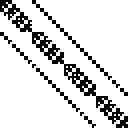

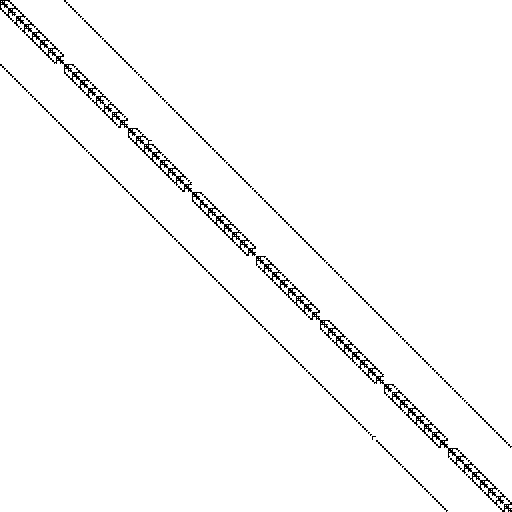

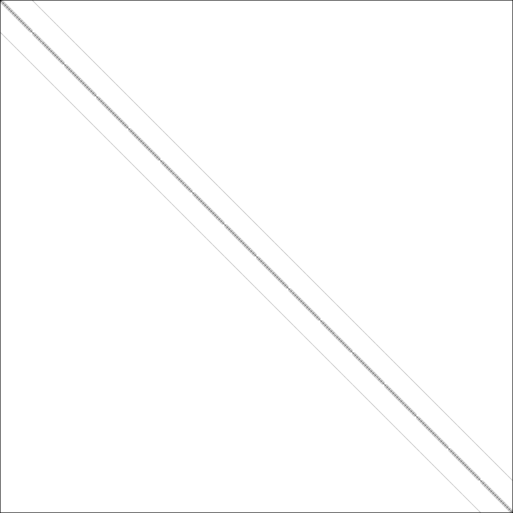

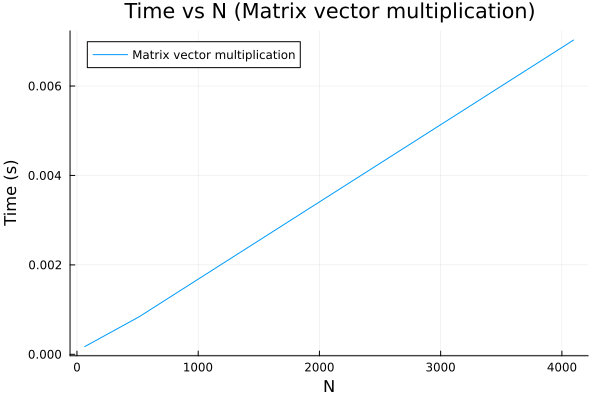

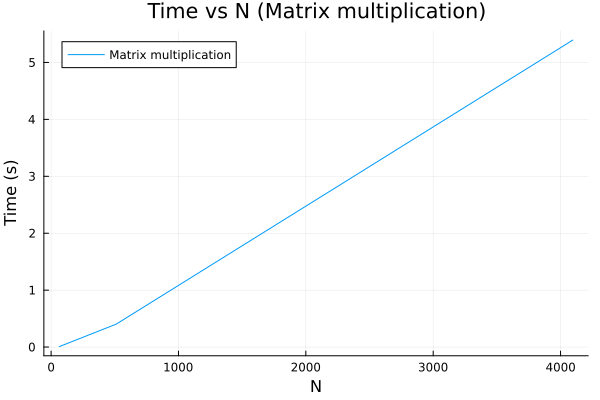

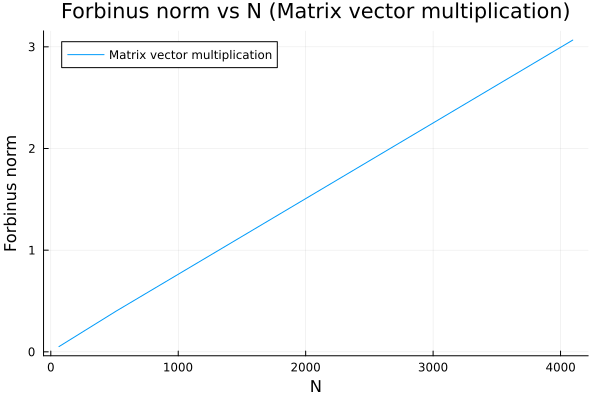

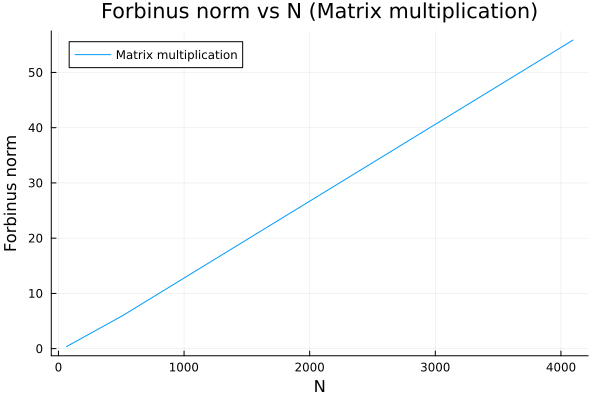

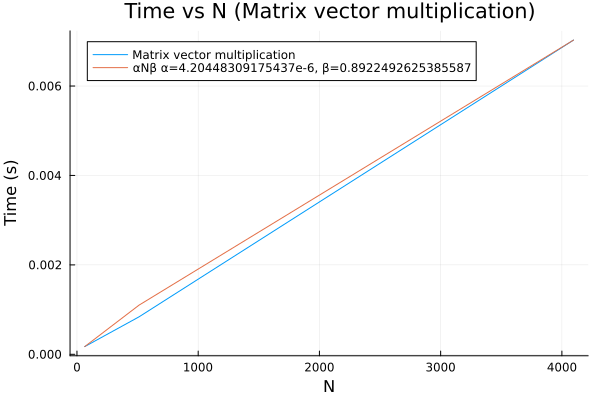

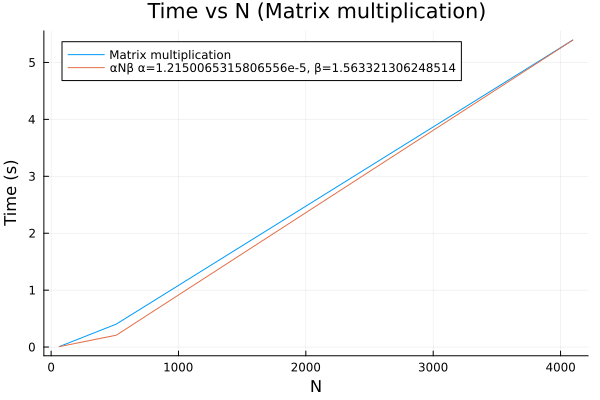

In [13]:
test(1, 0.1)

### Test dla gamma=2 i eps=0.2

cm_2^6_2-0.2.png
cm_2^9_2-0.2.png
cm_2^12_2-0.2.png


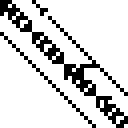

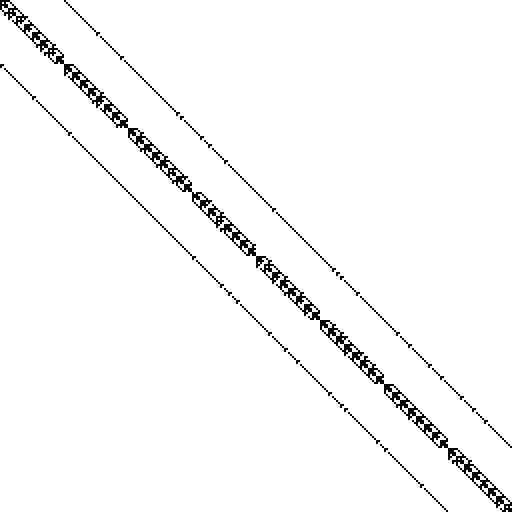

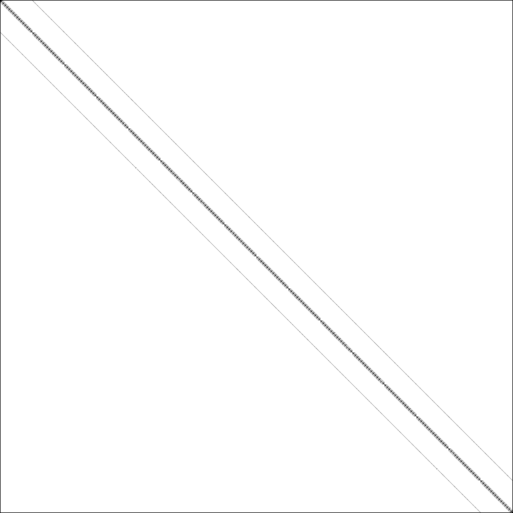

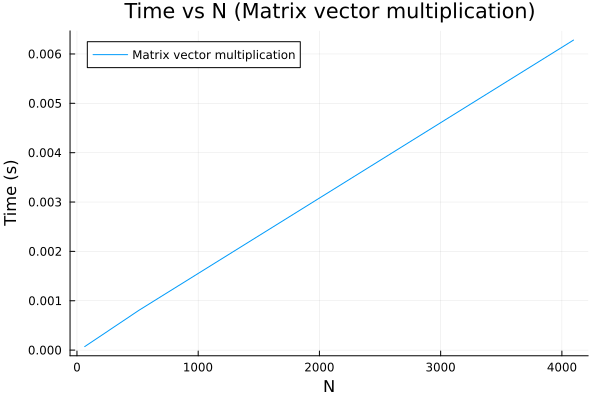

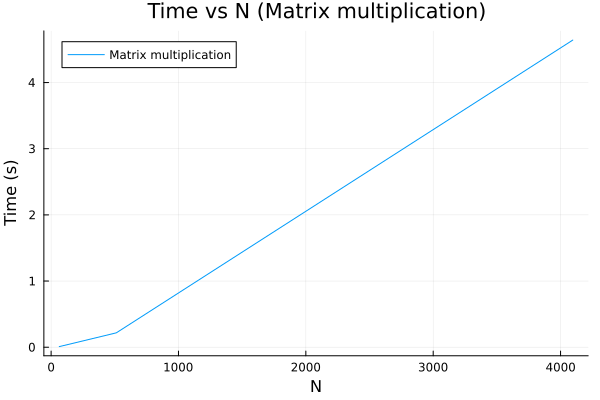

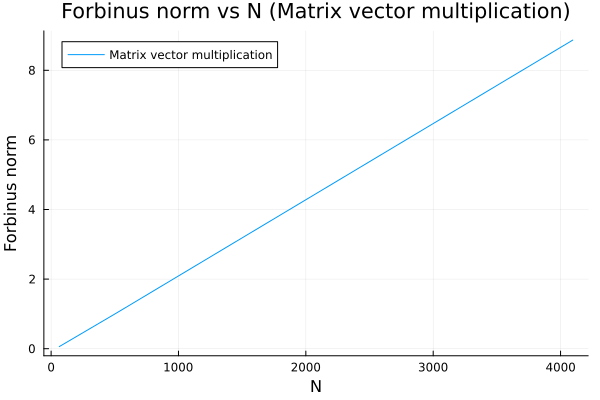

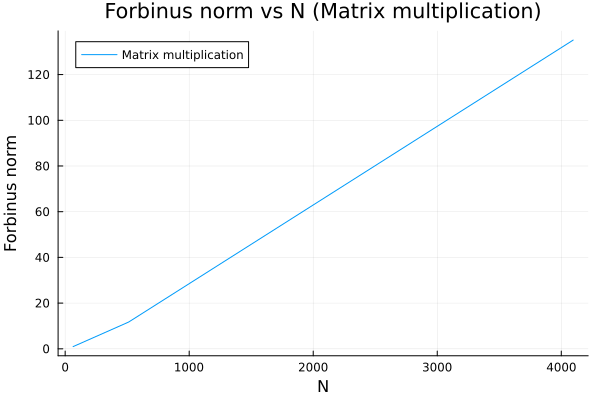

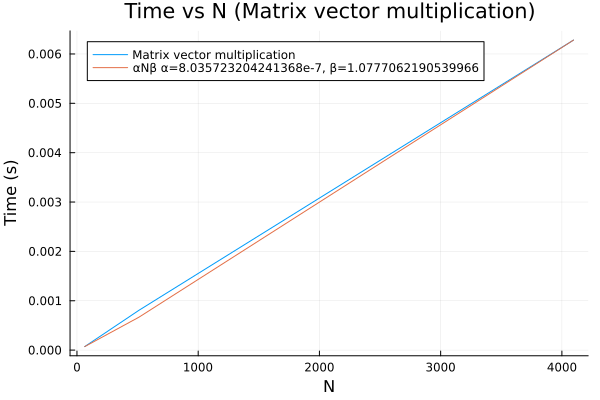

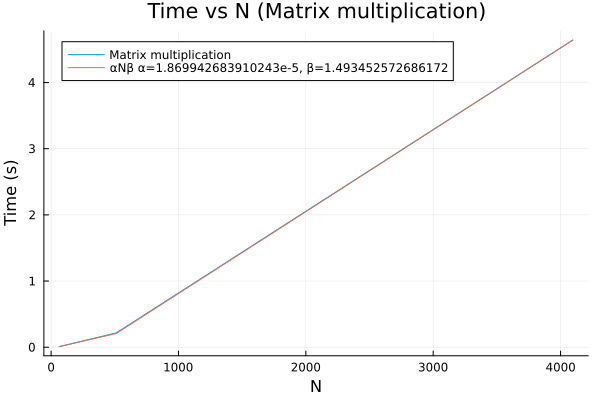

In [14]:
test(2, 0.2)

### Test dla gamma=3 i eps=0.3

cm_2^6_2-0.3.png
cm_2^9_2-0.3.png
cm_2^12_2-0.3.png


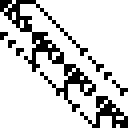

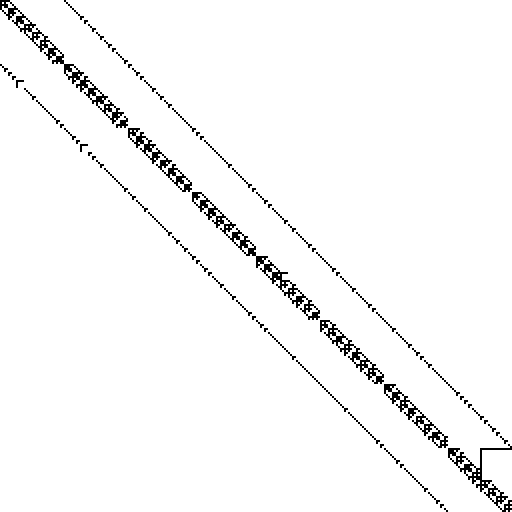

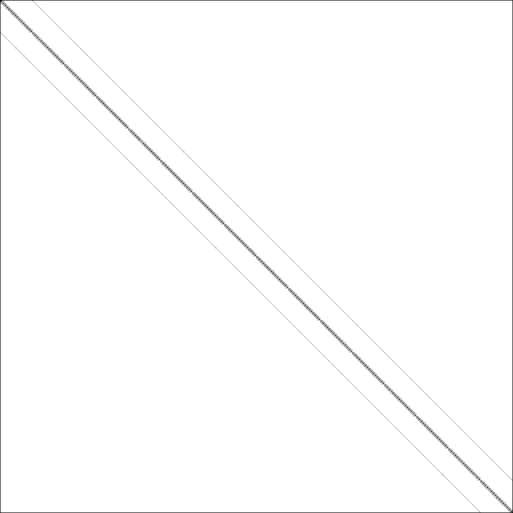

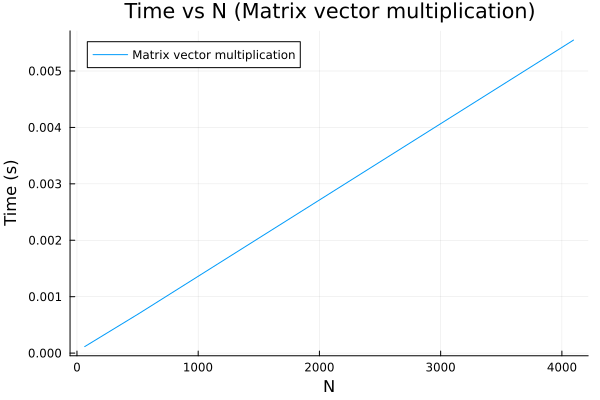

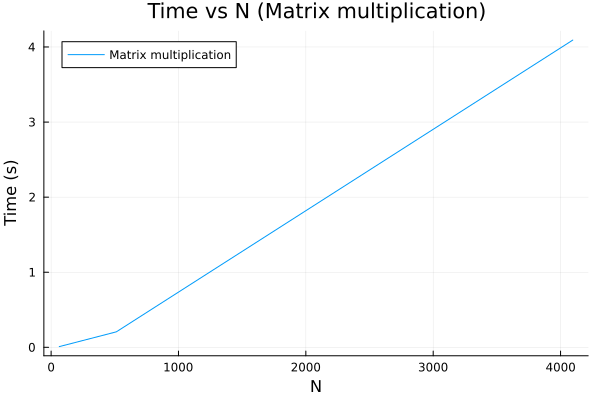

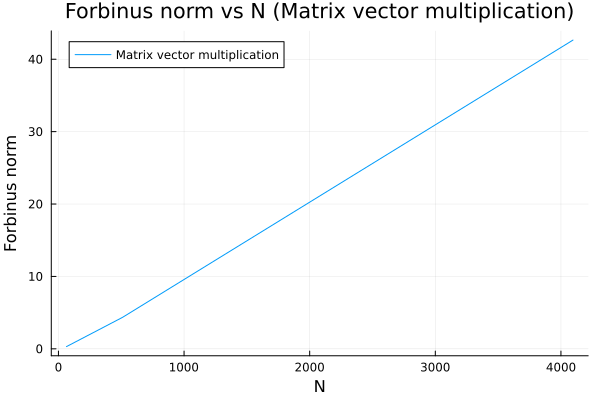

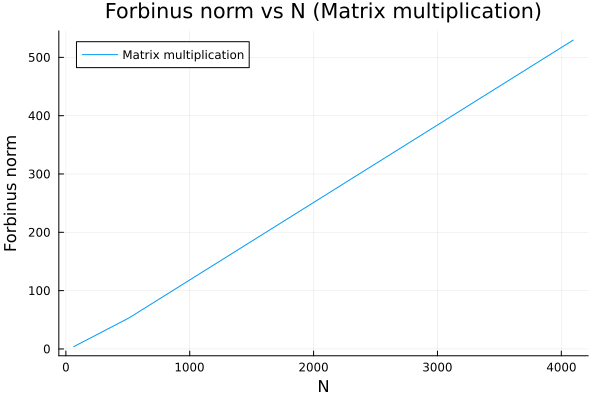

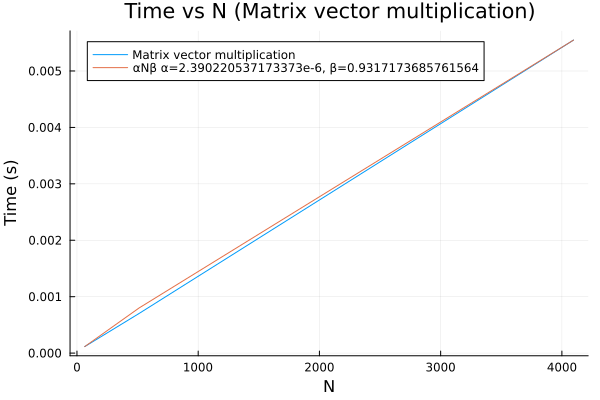

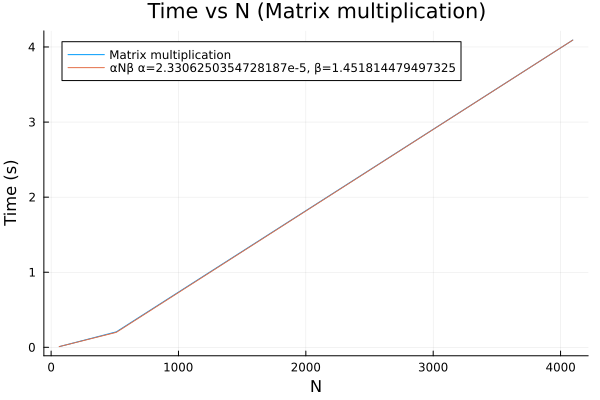

In [15]:
test(2, 0.3)